# Predicting Board Game Reviews

Board games have been making a comeback lately, and deeper, more strategic boardgames, like Settlers of Catan have become hugely popular. A popular site where these types of board games are discussed and reviewed is BoardGameGeek.

In this project, we'll be working with a dataset that contains 80000 board games and their associated review scores.

## Data Exploration

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline
from sklearn.cluster import KMeans

board_games = pd.read_csv('board_games.csv')

board_games.head()

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


Here are some of the interesting columns:

- name -- name of the board game.
- playingtime -- the playing time (given by the manufacturer).
- minplaytime -- the minimum playing time (given by the manufacturer).
- maxplaytime -- the maximum playing time (given by the manufacturer).
- minage -- the minimum recommended age to play.
- users_rated -- the number of users who rated the game.
- average_rating -- the average rating given to the game by users. (0-10)
- total_weights -- Number of weights given by users. Weight is a subjective measure that is made up by BoardGameGeek. It's how "deep" or involved a game is. [Here's](http://boardgamegeek.com/wiki/page/Weight) a full explanation.
- average_weight -- the average of all the subjective weights (0-5).

One interesting machine learning task will be to predict average_rating using the other columns. The dataset contains quite a few missing values, and rows where there are no reviews, where the score is 0. We'll need to remove these as we explore the data to make prediction easier.

In [17]:
board_games = board_games.dropna(axis=0)
board_games = board_games[board_games['users_rated'] > 0]

board_games.head()

,id,type,name,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,users_rated,average_rating,bayes_average_rating,total_owners,total_traders,total_wanters,total_wishers,total_comments,total_weights,average_weight
0,12333,boardgame,Twilight Struggle,2005.0,2.0,2.0,180.0,180.0,180.0,13.0,20113,8.33774,8.22186,26647,372,1219,5865,5347,2562,3.4785
1,120677,boardgame,Terra Mystica,2012.0,2.0,5.0,150.0,60.0,150.0,12.0,14383,8.28798,8.14232,16519,132,1586,6277,2526,1423,3.8939
2,102794,boardgame,Caverna: The Cave Farmers,2013.0,1.0,7.0,210.0,30.0,210.0,12.0,9262,8.28994,8.06886,12230,99,1476,5600,1700,777,3.7761
3,25613,boardgame,Through the Ages: A Story of Civilization,2006.0,2.0,4.0,240.0,240.0,240.0,12.0,13294,8.20407,8.05804,14343,362,1084,5075,3378,1642,4.1590
4,3076,boardgame,Puerto Rico,2002.0,2.0,5.0,150.0,90.0,150.0,12.0,39883,8.14261,8.04524,44362,795,861,5414,9173,5213,3.2943


## Picking An Error Metric

We want to predict the average_rating column using the other columns, but we'll need to do some data exploration before we're ready to do so. The exploration will help us understand the distribution of average_rating better, as well as select an error metric that we'll use to evaluate the performance of our machine learning model.

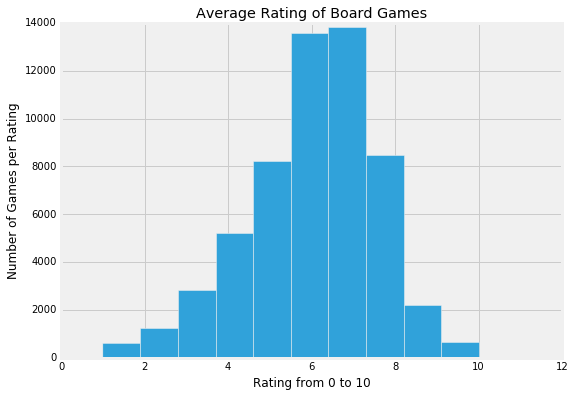

In [19]:
plt.figure(figsize=(8,6))
plt.title('Average Rating of Board Games')
plt.xlabel('Rating from 0 to 10')
plt.ylabel('Number of Games per Rating')
plt.hist(board_games['average_rating'])
plt.show()

In [24]:
print(board_games['average_rating'].std())
print(board_games['average_rating'].mean())

1.5788299348332662
6.016112849333889


In this data set, using mean squared error as an error metric makes sense. This is because the data is continuous, and follows a somewhat normal distribution. We'll be able to compare our error to the standard deviation to see how good the model is at predictions.

## Plotting Clusters
Now that we have a handle on the average_rating column, and have picked an error metric, we're ready for the next step. 

We can look at the data for patterns that may help us develop a machine learning model. One way to look for patterns is to use a clustering algorithm to create clusters, then plot them out.

We can first fit a KMeans class from the scikit-learn library. The KMeans class only works with numeric columns, so we have to extract the numeric columns of board_games before passing them into the fit method of the KMeans class.

To plot out the cluster assignment, we first find the mean and standard deviation of each row, then make a scatterplot for mean vs standard deviation, then shade the points according to their cluster assignment.

In [25]:
clus = KMeans(n_clusters=5)
cols = list(board_games.columns)
cols.remove('name')
cols.remove('id')
cols.remove('type')
numeric = board_games[cols]

clus.fit(numeric)

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=5, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=None, tol=0.0001,
    verbose=0)

In [26]:
game_mean = numeric.apply(np.mean, axis=1)
game_std = numeric.apply(np.std, axis=1)

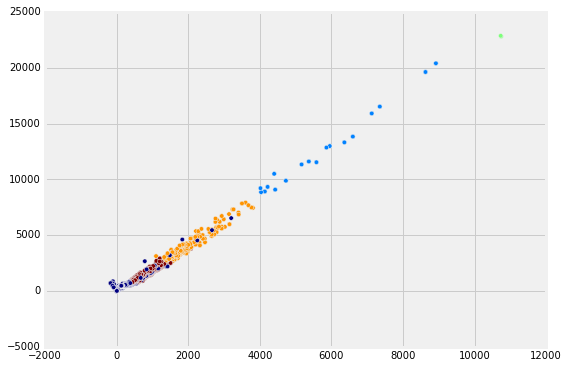

In [29]:
labels = clus.labels_
plt.figure(figsize=(8,6))
plt.scatter(x = game_mean, y = game_std, c = labels)
plt.show()

It looks like most of the games are similar, but as the game attributes tend to increase in value (such as number of users who rated), there are fewer high quality games. So most games don't get played much, but a few get a lot of players.

## Finding Correlations
Now that we've done some data exploration, we can figure out which columns correlate well with average_rating. This will enable us to remove columns that don't add much predictive power to the model. Columns that are uncorrelated with the target won't help a linear regression model, which is what we'll be using. It will also enable us to remove columns that are derived from the target, or otherwise cause overfitting.

In [30]:
correlations = numeric.corr()
correlations["average_rating"]

yearpublished           0.108461
minplayers             -0.032701
maxplayers             -0.008335
playingtime             0.048994
minplaytime             0.043985
maxplaytime             0.048994
minage                  0.210049
users_rated             0.112564
average_rating          1.000000
bayes_average_rating    0.231563
total_owners            0.137478
total_traders           0.119452
total_wanters           0.196566
total_wishers           0.171375
total_comments          0.123714
total_weights           0.109691
average_weight          0.351081
Name: average_rating, dtype: float64

The yearpublished column is surprisingly highly correlated with average_rating, showing that more recent games tend
to be rated more highly. Games for older players (minage is high) tend to be more highly rated. The more "weighty" a game is (average_weight is high), the more highly it tends to be rated.

## Creating A Model
We'll fit a linear regression model to board_games, using the columns we think should be predictors, and average_rating as the target. We'll then generate predictions using the same predictors you used in the fitting process. We are not going to use a training and testing set for this small project. 

In [31]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
cols.remove("average_rating")
cols.remove("bayes_average_rating")
reg.fit(board_games[cols], board_games["average_rating"])
predictions = reg.predict(board_games[cols])

np.mean((predictions - board_games["average_rating"]) ** 2)

2.0933969758339432

The error rate is close to the standard deviation of all board game ratings. This indicates that our model may not have high predictive power. We'll need to dig more into which games were scored well, and which ones weren't.

## Ideas for Extra Exploration

Here are some potential next steps:

- Split the data into training and testing sets, and calculate error on the testing set.
- Try algorithms other than linear regression.
- Calculate new predictors based off the existing columns, such as:
- Player range (maxplayers - minplayers)
- Playing time range (maxplaytime - minplaytime)
- Average number of ratings (total_owners / users_rated)
- Scrape the latest data from [BoardGameGeek](http://www.boardgamegeek.com/) to increase the size of the dataset.
- Scrape additional data from [BoardGameGeek](http://www.boardgamegeek.com/) to add in more columns.